In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [52]:
df = pd.DataFrame()

sensor1=np.loadtxt("sensor_data1.txt", delimiter=",")
sensor2=np.loadtxt("sensor_data2.txt", delimiter=",")

if len(sensor1) >= len(sensor2):
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")[:len(sensor2)]
else:
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")[:len(sensor1)]
    

In [53]:
#descartar primeras 1500 mediciones por sensiblidad de los sensores
df = df[1500:]

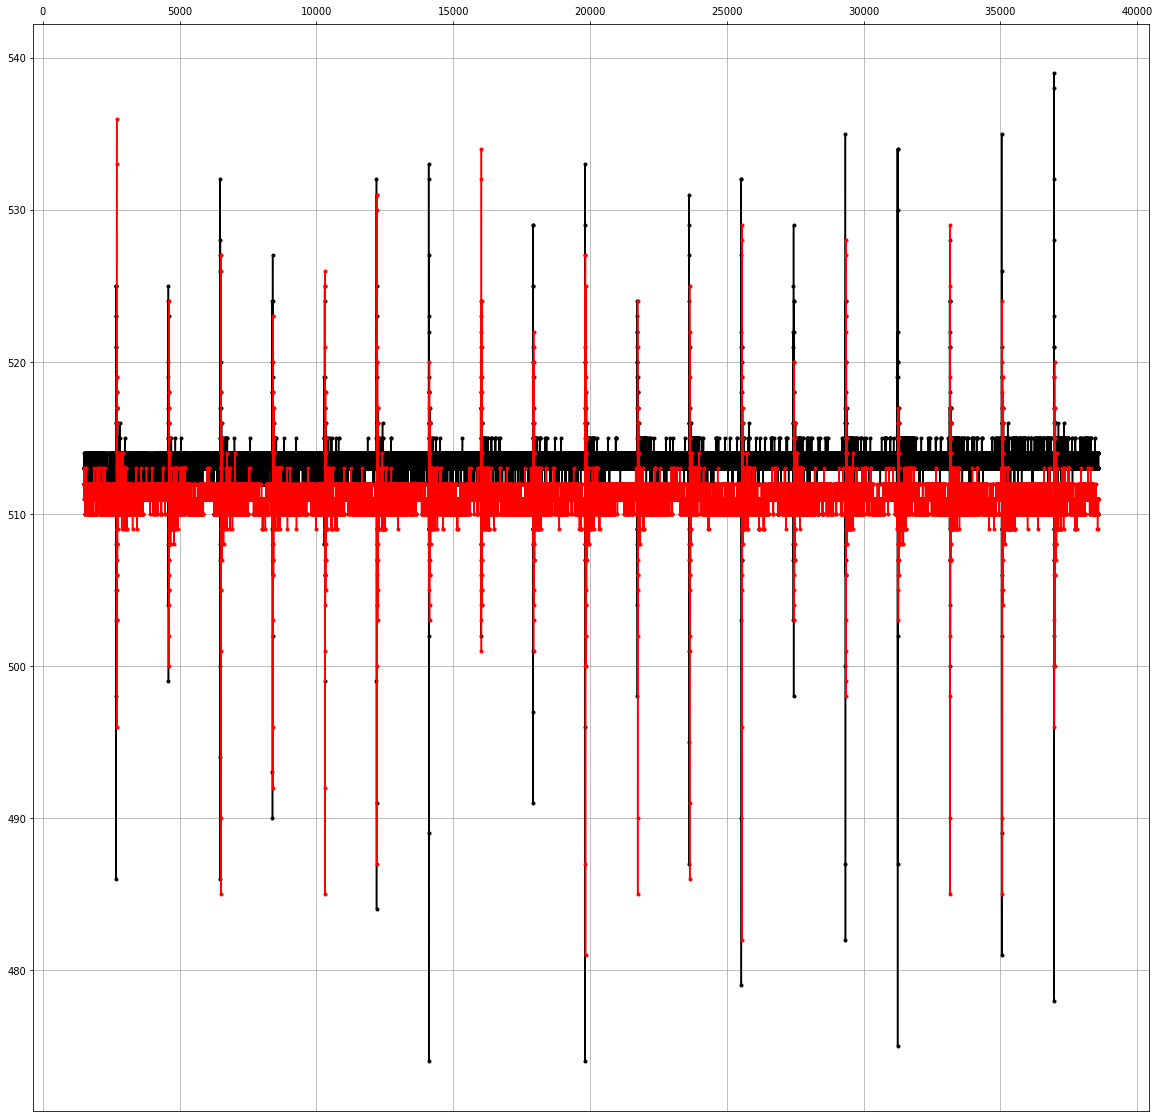

In [54]:
ax = plt.gca()
ax.xaxis.tick_top()
ax.plot(df.index, df["sensor1"], "k.-")
ax.plot(df.index, df["sensor2"], "r.-")
ax.grid()
fig = plt.gcf()
fig.set_size_inches(20, 20)
#x lim
a=4000
b=5000
#plt.xlim(0, 2000)

In [55]:
# n_mediciones_pico = abs(df.iloc[a:b, 0].idxmax()- df.iloc[a:b, 1].idxmax())
# n_mediciones_valle = abs(df.iloc[a:b, 0].idxmin()- df.iloc[a:b, 1].idxmin())
# n_mediciones_pico, n_mediciones_valle

In [56]:
# tiempo_pico = n_mediciones_pico*3/11369
# tiempo_valle = n_mediciones_valle*3/11369
# tiempo_pico, tiempo_valle

In [57]:
# distancia= 0.6
# distancia/tiempo_pico, distancia/tiempo_valle

In [58]:
# (distancia/tiempo_pico + distancia/tiempo_valle)/2


In [59]:
#import k-means
from sklearn.cluster import KMeans
df = df.reset_index().rename(columns={"index": "time"})

In [60]:
df

,time,sensor2,sensor1
0,1500,511.0,513.0
1,1501,512.0,513.0
2,1502,512.0,513.0
3,1503,512.0,513.0
4,1504,511.0,513.0
...,...,...,...
37082,38582,511.0,513.0
37083,38583,511.0,514.0
37084,38584,511.0,514.0
37085,38585,511.0,513.0


In [61]:
#identify 20 groups in df_sensor1 by k-means taking time and values into account
pulses_number = 20 #tiempo de medición en segundos por frecuencia de emisión bits/segundo
kmeans_sensor1 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor1"]])
kmeans_sensor2 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor2"]])

#write the clasification for each row in df_sensor1
df["sensor1_pulse"]=kmeans_sensor1.labels_
df["sensor2_pulse"]=kmeans_sensor2.labels_

In [64]:
df.query("sensor1_pulse == 0")["sensor1"].idxmax(), df.query("sensor2_pulse == 0")["sensor2"].idxmax()

(12601, 12630)

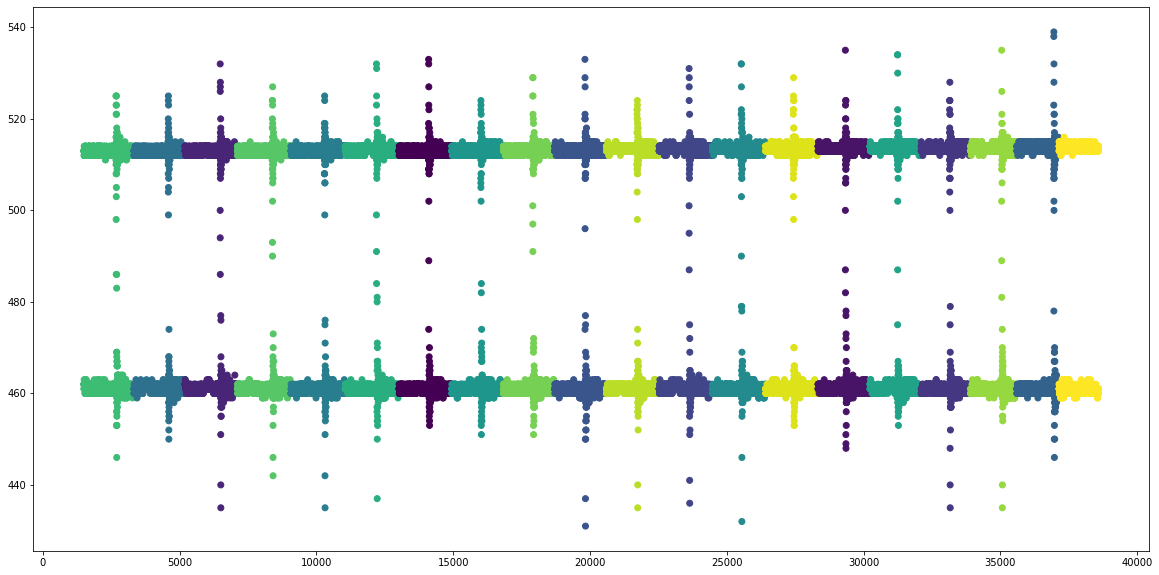

In [65]:
#plot the clasification
plt.figure(figsize=(20, 10))
plt.scatter(df["time"], df["sensor1"], c=df["sensor1_pulse"])
plt.scatter(df["time"], df["sensor2"] - 50, c=df["sensor2_pulse"])
#plt.xlim(4000, 5000)
plt.show()


In [66]:
df.query("sensor1_pulse == 4")["sensor1"].idxmax(), df.query("sensor2_pulse == 4")["sensor2"].idxmax()

(22121, 22141)

In [67]:
#identify the time of the peak for each group
peaks1 = df[["sensor1", "sensor1_pulse"]].groupby("sensor1_pulse").idxmax().reset_index().rename(columns={"sensor1_pulse": "pulse"})

for pulse in peaks1["pulse"]:
    pulse_df = df.query(f"sensor1_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor1"].max()) < pulse_df["sensor1"].mean() + 3*pulse_df["sensor1"].std():
        peaks1 = peaks1.query(f"pulse != {pulse}")

peaks2 = df[["sensor2", "sensor2_pulse"]].groupby("sensor2_pulse").idxmax().reset_index().rename(columns={"sensor2_pulse": "pulse"})

for pulse in peaks2["pulse"]:
    pulse_df = df.query(f"sensor2_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor2"].max()) < pulse_df["sensor2"].mean() + 3*pulse_df["sensor2"].std():
        peaks2 = peaks2.query(f"pulse != {pulse}")


In [68]:
peaks = pd.merge(peaks1, peaks2, on="pulse")

In [69]:
peaks

,pulse,sensor1,sensor2
0,0,12601,12630
1,1,27834,27858
2,2,4981,5002
3,3,31654,31669
4,4,22121,22141
5,5,18314,18332
6,6,35456,35482
7,7,3087,3110
8,8,8799,8817
9,9,24028,24048


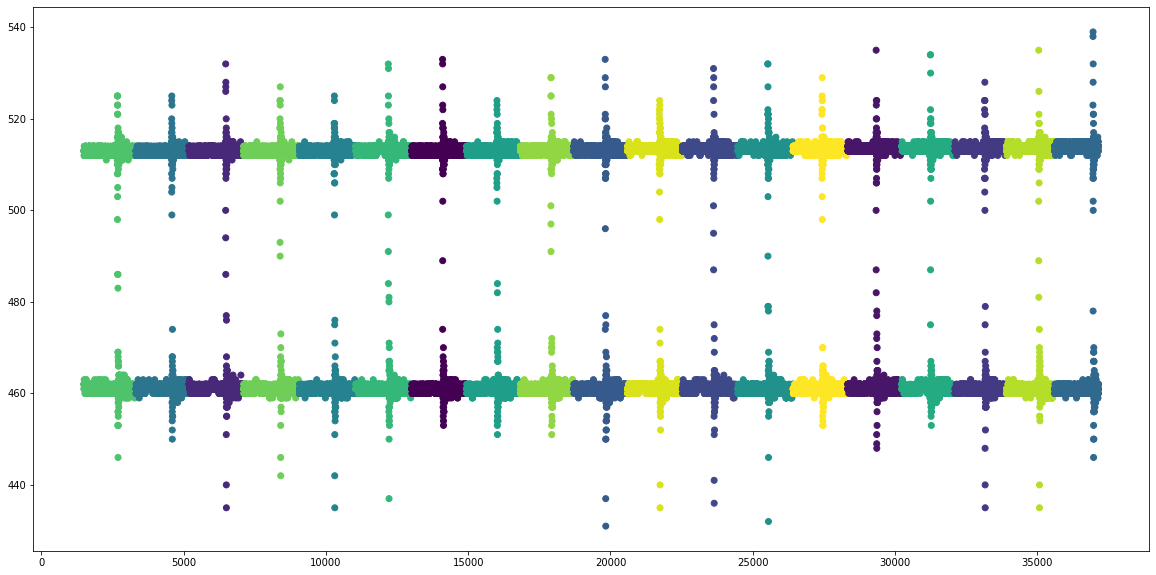

In [73]:
#plot the clasification
df_filtered = df.query("sensor1_pulse in @peaks.pulse and sensor2_pulse in @peaks.pulse")
plt.figure(figsize=(20, 10))
plt.scatter(df_filtered["time"], df_filtered["sensor1"], c=df_filtered["sensor1_pulse"])
plt.scatter(df_filtered["time"], df_filtered["sensor2"] - 50, c=df_filtered["sensor2_pulse"])
#plt.xlim(4000, 5000)
plt.show()

In [74]:
abs(peaks["sensor1"] - peaks["sensor2"]).mean(), abs(peaks["sensor1"] - peaks["sensor2"]).std()

(20.63157894736842, 5.335525865114885)

In [75]:
time = abs(peaks["sensor1"] - peaks["sensor2"]).mean()*3/11369
distance = 0.6
speed = distance/time

In [76]:
speed

110.20969387755102